## Урок 6. Нейросети в обработке текста
Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
!pip install stop-words pymorphy2

In [2]:
!pip install nltk

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
#nltk.download()
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
max_words = 1000
max_len = 10
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [8]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [9]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [10]:
X_valid.label.value_counts()

0    7432
1     559
Name: label, dtype: int64

In [11]:
sw = set(get_stop_words("en"))

In [12]:
puncts = set(punctuation)

In [13]:
morpher = MorphAnalyzer()
morpher = WordNetLemmatizer()
morpher.lemmatize('dogs')

'dog'

In [14]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [15]:
from tqdm import tqdm 
tqdm.pandas()

X_train.tweet = X_train.tweet.progress_apply(preprocess_text)
X_valid.tweet = X_valid.tweet.progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████| 7991/7991 [00:01<00:00, 7417.05it/s]


In [16]:
train_corpus = " ".join(X_train.tweet)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:5]

['weekend', 'world', 'really', 'going', 'bonkers']

In [17]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [18]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  
len(tokens_filtered_top)

999

In [19]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'u', 'happy', 'amp', 'just', 'will', 'time', 'life']

In [20]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [21]:
def text_to_sequence(text, maxlen):
    
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()] 
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    
    return result[-maxlen:] + padding

In [22]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_valid.tweet])

x_train.shape, x_val.shape

Wall time: 7.16 s


((23971, 10), (7991, 10))

In [23]:
train_df.tweet.iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [24]:
x_train[0]

array([35,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [25]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=64, out_channel=64, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [26]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() 
        self.target = torch.from_numpy(target).long() 
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [27]:
train_dataset = DataWrapper(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_valid.label.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [28]:
train_loader.sampler

In [29]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [30]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [31]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(1000, 64)
  (conv_1): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=64, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)
Parameters: 86721


In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
criterion = nn.BCELoss() 

In [33]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

       
        loss = loss.item()
        running_items += len(labels)
        
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

C:\Users\Tato\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/15]. Step [47/47]. Loss: 0.195. Acc: 0.913. Test loss: 0.019. Test acc: 0.930
Epoch [2/15]. Step [47/47]. Loss: 0.174. Acc: 0.934. Test loss: 0.007. Test acc: 0.937
Epoch [3/15]. Step [47/47]. Loss: 0.154. Acc: 0.946. Test loss: 0.003. Test acc: 0.942
Epoch [4/15]. Step [47/47]. Loss: 0.106. Acc: 0.953. Test loss: 0.031. Test acc: 0.936
Epoch [5/15]. Step [47/47]. Loss: 0.125. Acc: 0.963. Test loss: 0.027. Test acc: 0.940
Epoch [6/15]. Step [47/47]. Loss: 0.111. Acc: 0.969. Test loss: 0.614. Test acc: 0.942
Epoch [7/15]. Step [47/47]. Loss: 0.075. Acc: 0.975. Test loss: 1.875. Test acc: 0.938
Epoch [8/15]. Step [47/47]. Loss: 0.089. Acc: 0.977. Test loss: 0.014. Test acc: 0.937
Epoch [9/15]. Step [47/47]. Loss: 0.049. Acc: 0.981. Test loss: 1.677. Test acc: 0.936
Epoch [10/15]. Step [47/47]. Loss: 0.075. Acc: 0.982. Test loss: 0.012. Test acc: 0.939
Epoch [11/15]. Step [47/47]. Loss: 0.056. Acc: 0.984. Test loss: 0.115. Test acc: 0.934
Epoch [12/15]. Step [47/47]. Loss: 0.045.

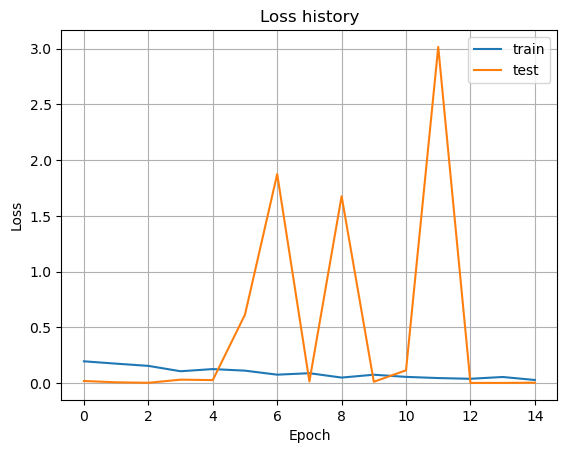

In [34]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

В данном случан точность модели не сильно зависит от изменения параметров 

 